# RL4CRN tutorial notebook: stochastic RPA with noise reduction (SSA)

Refer to the Logic Circuits tutorial for more information about the overall pipeline.

In this notebook, we will use SSA simulations under the hood to learn I/O CRNs based on the mean and variance of their output species.


In [1]:
import os, sys, numpy as np

print("Python:", sys.version.split()[0])
print("CWD:", os.getcwd())


Python: 3.10.12
CWD: /local0/rossin/git/GenAI-Net/apps


## 1) Import RL4CRN helpers


In [2]:
from RL4CRN.utils.input_interface import (
    Configurator,
    make_task,
    make_session_and_trainer,
    print_task_summary,
)
from RL4CRN.utils.default_tasks.SSARobustTaskKind import SSARobustTaskKind


## 2) Build a template IO/CRN

Here we use the convenience builder `build_simple_IOCRN`, which provides an easy way to construct a I/O CRNs specifying dictionaries for input and output nodes.


In [3]:
from RL4CRN.utils.crn_builders import build_simple_IOCRN

# choose preset
cfg = Configurator.preset("paper")

# select simulator and set tolerances 
# (this controls the deterministic simulations, just for post-analysis and visualization)
cfg.solver.algorithm = "CVODE"
cfg.solver.rtol = 1e-10
cfg.solver.atol = 1e-10

# build template IO/CRN
species_labels = ['Z_1', 'Z_2', 'X_1']
crn, species_labels = build_simple_IOCRN(
    species=species_labels,
    production_input_map={"Z_1": "u_1"},
    degradation_input_map={"X_1": "u_2"},
    dilution_map={},
    output_species="X_1",
    solver=cfg.solver,
)

print("Template CRN built.")
print(" - num_inputs:", crn.num_inputs)
print(" - num_species:", len(species_labels))
print(" - species:", species_labels)


Template CRN built.
 - num_inputs: 2
 - num_species: 3
 - species: ['Z_1', 'Z_2', 'X_1']


## 3) Build the reaction library (MAK)


In [4]:
from RL4CRN.utils.library_builders import build_MAK_library

# library components
library_components = build_MAK_library(crn, species_labels, order=2)

library, M, K, masks = library_components
print("Library built.")
print(" - M (num reactions in library):", M)
print(" - K (num parameters in library):", K)


Library built.
 - M (num reactions in library): 91
 - K (num parameters in library): 91


## 4) Define the task: RPA

- `kind="oscillator_mean"` selects the reward handler.
- `ic=("constant", 0.01)` sets initial concentrations.
- we use `u_values` to identify the combinations between input and disturbance
- we use `targets` to highlight the target output we seek to reach


In [5]:
SSARobustTaskKind.pretty_help()

### TaskKind `ssa_robust`

**Required params**
- `target`: float OR callable with named args (recommended)
- `u_values`: List[float] values used for default grid inputs

**Optional params**
- `n_inputs`: int (defaults to template_crn.num_inputs)
- `t_f`: float (default 100.0)
- `n_t`: int (default 1000)
- `ic`: IC spec
- `relative`: bool (default False) whether to use relative error or absolute error
- `weights`: weights spec
- `u_list`: explicit list of inputs (overrides defaults)
- `u_spec`: ('custom'|'grid'|'linspace', ...) escape hatch
- `n_trajectories`: int (default 256)
- `max_threads`: int (default 1024)
- `cv_weight`: float (default 1.0)
- `rpa_weight`: float (default 1.0)
- `norm`: int (default 1)
- `LARGE_NUMBER`: float (default 1e4)
- `LARGE_PENALTY`: float (default 1e4)

**Notes**
- Default u_list is cartesian product over u_values repeated n_inputs. Callable target arg names
  resolve via input_idx_dict/species_idx_dict.


In [6]:
task = make_task(
    template_crn=crn,
    library_components=library_components,
    kind="ssa_robust",
    species_labels=species_labels,
    params={
        "t_f": 100,
        "n_t": 100,
        "ic": ("constant", 0.01),
        "weights": "transient",
        "u_values": [0.5, 1.0, 1.5], # the product (per input) of all the combinations of these values will be used 
        "target" : lambda u_1: 3.0 * u_1, # we can use arbitrary callables as targets, with named args resolved via the template CRN's input_idx_dict (Inputs) and species_idx_dict (ICs)
        "n_trajectories": 1024,
        "LARGE_NUMBER": 1e3
    }
)

print_task_summary(task)

# --- Optional safety checks (recommended) ---
print("Sanity checks:")
print(" - template num_inputs:", crn.num_inputs)
print(" - first u shape:", np.asarray(task.u_list[0]).shape)
print(" - first u length:", len(task.u_list[0]))
assert len(task.u_list[0]) == crn.num_inputs, "Input dimension mismatch: u has wrong length!"


Task: ssa_robust
time_horizon: (100,) [0..100.0]
num scenarios: 9
first 3 u: [array([0.5, 0.5], dtype=float32), array([0.5, 1. ], dtype=float32), array([0.5, 1.5], dtype=float32)]

Sanity checks:
 - template num_inputs: 2
 - first u shape: (2,)
 - first u length: 2


## 5) Training configuration

We tune:
- `max_added_reactions`: episode length (how many reactions the agent can add)
- `epochs`: training iterations
- `render_every`: print progress cadence
- `seed`: reproducibility


In [7]:
# ---- Train config ----
cfg.train.max_added_reactions = 5
cfg.train.epochs = 5
cfg.train.render_every = 1
cfg.train.seed = 0

# IMPORTANT: set the number to CPUs to a low number (e.g. 4) as the SSA simulations are handled by the GPU!
cfg.train.n_cpus = 4
cfg.train.batch_size = 160

In [8]:
cfg.render.n_best = 20
cfg.render.disregarded_percentage = 0.9
cfg.render.mode = {  # Mode of the experiment
    'style': 'logger', 
    'task': 'SSA_transients', 
    'format': 'image',
    'topology': True
}

## 6) Inspect full configuration (optional)

`cfg.describe()` prints a nested configuration dictionary.


In [9]:
cfg.describe()

{'task': None,
 'solver': {'algorithm': 'CVODE', 'rtol': 1e-10, 'atol': 1e-10},
 'train': {'epochs': 5,
           'max_added_reactions': 5,
           'render_every': 1,
           'hall_of_fame_size': 50,
           'batch_multiplier': 10,
           'seed': 0,
           'n_cpus': 4,
           'batch_size': 160},
 'policy': {'width': 1024,
            'depth': 5,
            'deep_layer_size': 10240,
            'continuous_distribution': {'type': 'lognormal_1D'},
            'entropy_weights_per_head': {'structure': 2.0, 'continuous': 1.0, 'discrete': 0.0, 'input_influence': 0.0},
            'ordering_enabled': False,
            'constraint_strength': inf},
 'agent': {'learning_rate': 0.0001,
           'entropy_scheduler': {'entropy_weight': 0.001,
                                 'topk_entropy_weight': 1.0,
                                 'remainder_entropy_weight': 1.0,
                                 'entropy_update_coefficient': 1,
                                 'entrop

## 7) Create session + trainer

This step wires together:
- parallel environments
- observer/tensorizer/actuator/stepper interfaces
- policy + agent
- the chosen task reward function

The returned object:
- `trainer`: runs rollout → reward eval → policy update loops


In [10]:
import os
from datetime import datetime
from pytorch_lightning.loggers import CometLogger

task_name = "StochasticRPA_Task"
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Expect these in your environment:
#   COMET_API_KEY   (required)
#   COMET_WORKSPACE (required)
api_key = os.environ["COMET_API_KEY"]
workspace = os.environ["COMET_WORKSPACE"]

logger = CometLogger(
    api_key=api_key,
    project=task_name,
    workspace=workspace,
    name=f"{task_name}_{timestamp}",
)

logger = logger.experiment


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/redsnic/stochasticrpa-task/d74a60cc429a4d3cb98ee968b488efe0



In [11]:
trainer = make_session_and_trainer(cfg, task, logger=logger)

## 8) Train and save checkpoints

We run for `cfg.train.epochs` epochs and periodically save a checkpoint.


In [ ]:
checkpoint_path = "SSA_RPA_task_chkpt.pkl"
trainer.run(epochs=cfg.train.epochs, checkpoint_path=checkpoint_path)

[epoch 0] best loss=1.249 | median loss=5.312
Saved checkpoint: SSA_RPA_task_chkpt.pkl
[epoch 1] best loss=1.04 | median loss=6.96
Saved checkpoint: SSA_RPA_task_chkpt.pkl


## 9) Inspect the best CRN

The trainer keeps a **Hall of Fame** of good CRNs found during rollouts.


Best CRN loss: 0.5783418584475515
Inputs: ['u_1', 'u_2'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_3;  [MAK(1.0, u_2)]
X_1 ----> ∅;  [MAK(0.545262336730957)]
X_1 ----> X_1 + X_3;  [MAK(0.3946678042411804)]
X_1 ----> X_2 + X_2;  [MAK(1.268619179725647)]
X_1 + X_2 ----> X_1 + X_3;  [MAK(0.8701299428939819)]
X_3 + X_3 ----> X_3;  [MAK(1.0470017194747925)]
Hall of Fame size: 50
Best loss: 0.5783418584475515


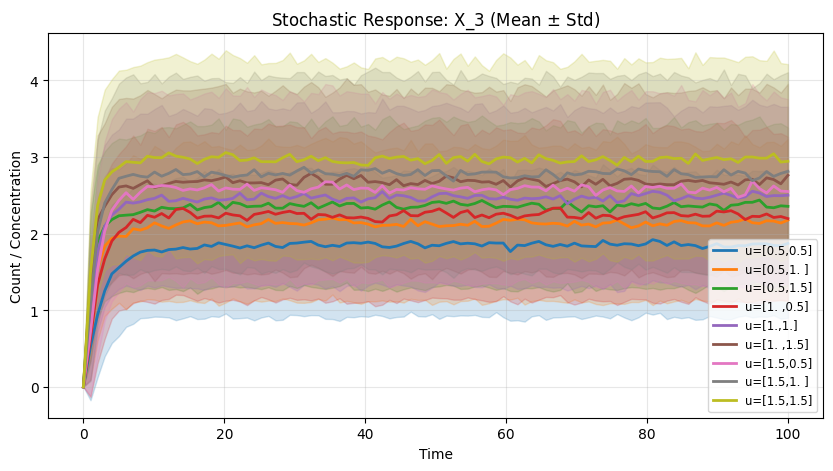

In [ ]:
trainer.inspect_best(plot=True)

best = trainer.best_crn()
print("Hall of Fame size:", len(trainer.s.mult_env.hall_of_fame))
if best is not None:
    print("Best loss:", best.last_task_info.get("reward", None))


## 10) Sample and re-simulate

After training, we can **draw new CRN designs from the learned policy** (sampling runs in evaluation mode, i.e., no gradient updates) and **re-evaluate** them.

This is useful for:
- **Model exploration:** quickly inspect diverse candidates generated by the policy.
- **Controlled re-simulation:** re-run sampled CRNs under modified conditions (`u_list/u_spec`, `ic`, etc.).

Sampling produces a dedicated **sample Hall-of-Fame** that stores the best `K` sampled environments (lowest loss) for later inspection and checkpointing.


In [ ]:
trainer.sample(10, 10, ic=("constant", 1.0)) 

We can now inspect newly sampled I/O CRNs.

Inputs: ['u_1', 'u_2'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_3;  [MAK(1.0, u_2)]
X_1 ----> ∅;  [MAK(1.0689938068389893)]
X_3 ----> X_2 + X_2;  [MAK(0.6776185631752014)]
X_2 + X_2 ----> X_3;  [MAK(0.4163484573364258)]
X_2 + X_2 ----> X_1 + X_3;  [MAK(0.9696062207221985)]
X_2 + X_3 ----> X_2 + X_2;  [MAK(1.142096996307373)]
reward: 0.8356053932735249


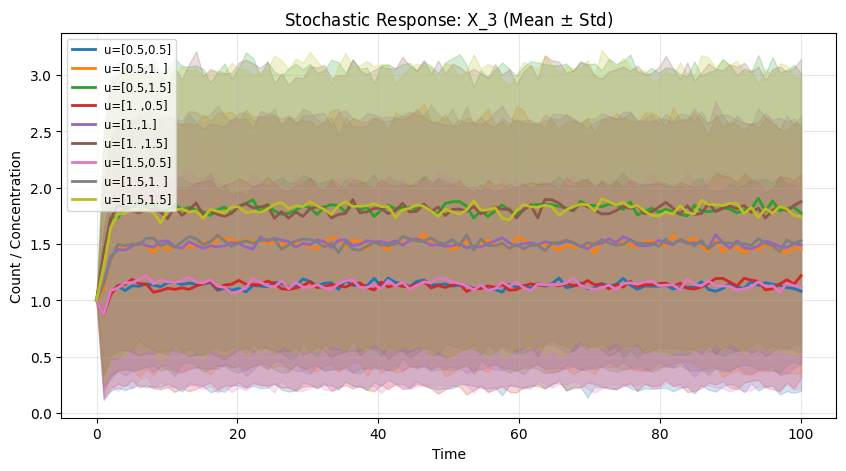

In [ ]:
import matplotlib.pyplot as plt

index = 0
crn_s = trainer.get_sampled_crns()[index]
print(crn_s)
print("reward:", crn_s.last_task_info.get("reward", None))

# Plotters depend on your IOCRN implementation
crn_s.plot_SSA_transient_response(); plt.show()


Save again our results.

In [ ]:
trainer.save(checkpoint_path)

Saved checkpoint: RPA_task_chkpt.pkl


## 11) Loading a saved Session/Trainer from a checkpoint

`load_session_and_trainer` reconstructs wiring and restores weights, history, HoFs, and RNG states.


Best CRN loss: 0.2351506629033186
Inputs: ['u_1', 'u_2'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_3;  [MAK(1.0, u_2)]
X_1 ----> X_2 + X_3;  [MAK(0.1489453762769699)]
X_1 ----> X_3 + X_3;  [MAK(0.8714479207992554)]
X_3 ----> X_2 + X_2;  [MAK(0.9133807420730591)]
X_1 + X_2 ----> X_1;  [MAK(0.4946763515472412)]
X_3 + X_3 ----> X_2 + X_2;  [MAK(0.7640494704246521)]


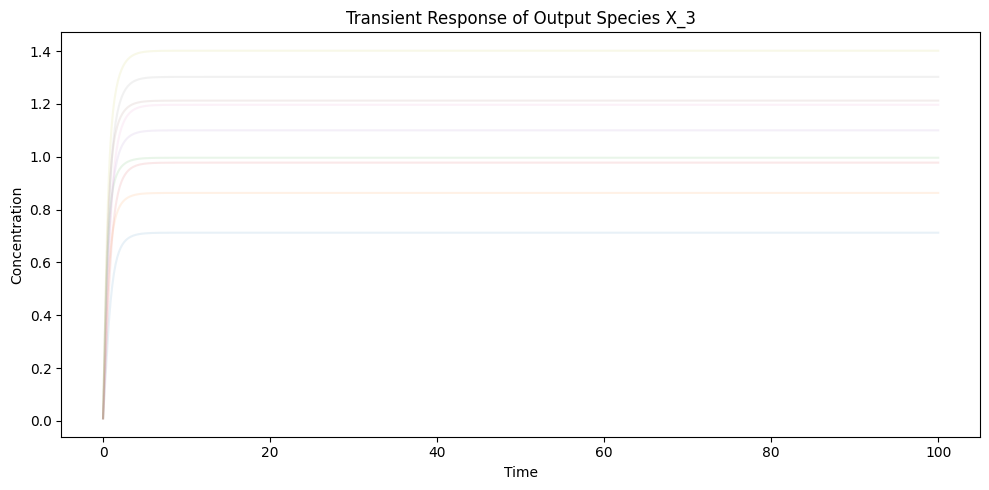

In [ ]:
from RL4CRN.utils.input_interface import load_session_and_trainer

trainer_loaded = load_session_and_trainer(checkpoint_path, device="cuda")
trainer_loaded.inspect_best()

## 12) Re-simulate Hall-of-Fame CRNs under new conditions

We can take the training Hall-of-Fame CRNs and re-simulate them under a new IC and/or new input set.

This uses `Trainer.resimulate(...)` which clones CRNs before evaluation (so old results remain intact).


CRN loss: 0.21658467684121893
Inputs: ['u_1', 'u_2'] 
Species: ['X_1', 'X_2', 'X_3'] 
Output Species: ['X_3'] 
∅ ----> X_1;  [MAK(1.0, u_1)]
∅ ----> X_3;  [MAK(1.0, u_2)]
X_1 ----> X_2 + X_3;  [MAK(0.1489453762769699)]
X_1 ----> X_3 + X_3;  [MAK(0.8714479207992554)]
X_3 ----> X_2 + X_2;  [MAK(0.9133807420730591)]
X_1 + X_2 ----> X_1;  [MAK(0.4946763515472412)]
X_3 + X_3 ----> X_2 + X_2;  [MAK(0.7640494704246521)]


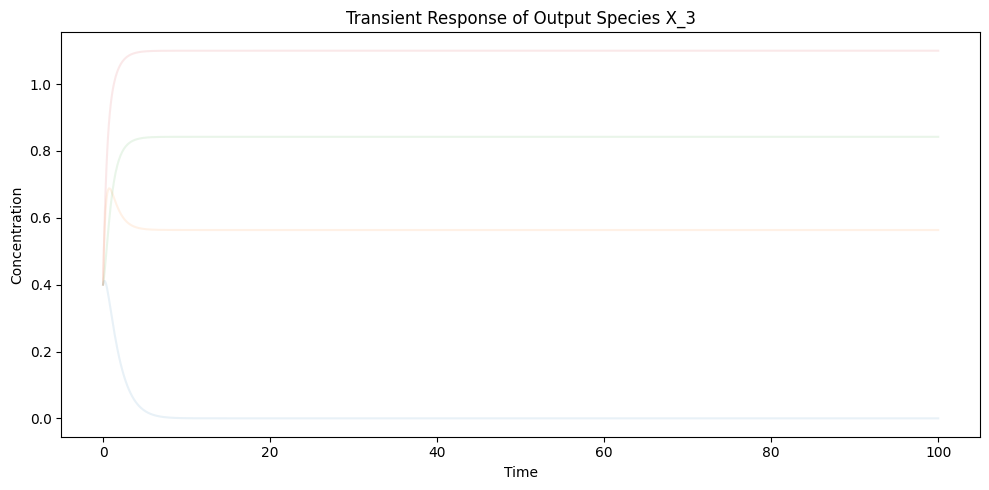

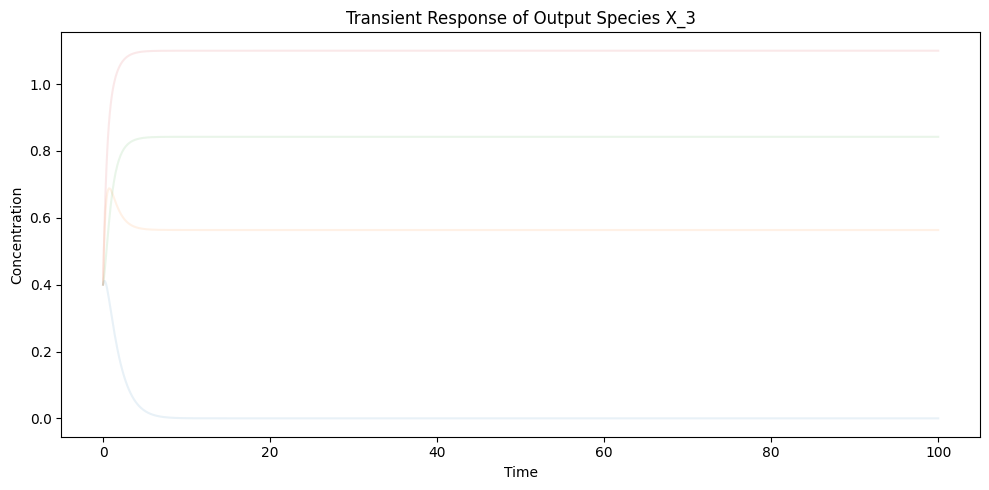

In [ ]:
hof_crns = [item.state for item in trainer.s.mult_env.hall_of_fame]

trainer.s.crn_template

crns_new = trainer.resimulate(
    hof_crns,
    ic=("constant", 0.4), 
    u_spec=("grid", [0.0, 1.0]),
)

trainer.inspect(crns_new[0])
crns_new[0].plot_transient_response(); plt.show()
